-----------------------------------------------------------------------------------------------------------------------
# **Crude Oil Production Forecasting**
-----------------------------------------------------------------------------------------------------------------------

----------------
## **Context** 
----------------

The world economy relies heavily on hydrocarbons, particularly oil, for the provision of energy required in transportation and other industries. Crude oil production is considered one of the most important indicators of the global economy. Dependence on oil and its finite nature, pose some complex problems including estimation of future production patterns. 

Crude oil production forecasting is an important input into the decision-making process and investment scenario evaluation, which are crucial for oil-producing countries. Governments and businesses spend a lot of time and resources figuring out the production forecast that can help to identify opportunities and decide on the best way forward.

------------------
## **Objective**
------------------

Analyze and use historical oil production data, from 1992 to 2018, for a country to forecast its future production. We will build a time series forecasting model using the AR, MA, ARMA, and ARIMA models in order to forecast oil production. 

--------------------------
## **Data Dictionary**
--------------------------

The dataset that we will be using is 'Crude Oil Production by Country'. This dataset contains the yearly oil production of 222 countries, but for simplicity, we will use only one country to forecast its future oil production.

## **Importing necessary libraries**

**Note**: The Statsmodels library is being downgraded to version 0.12.1 for the purpose of this case study. This is because the library has only recently been updated, and the latest version may / may not give us the desired Time Series output results. The code below (!pip install statsmodels==0.12.1) may be run in order to downgrade the library to the right version.

To be sure you are using the correct version of the Statsmodels library, you can use the code in the version check cell right after, and **version 0.12.1** should be good to go.

We also need to install pmdarima library to successfully execute the last cell of this case study.

Once the below installation codes run successfully, you may either restart the kernel or restart the Jupyter Notebook before importing the libraries. It is enough to run the below installation cells only once.

In [1]:
# Libraries to do data manipulation
import numpy as np

import pandas as pd

# Library to do data visualization
import matplotlib.pyplot as plt

# Library to do time series decomposition
import statsmodels.api as sm

# Module to create ACF and PACF plots
from statsmodels.graphics import tsaplots

# Module to build AR, MA, ARMA, and ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Module to implement MSE and RSME during model evaluation
from sklearn.metrics import mean_squared_error

# Code for ignoring unnecessary warnings while executing some code  
import warnings
warnings.filterwarnings("ignore")

## **Loading the dataset**

This dataset has crude oil production data as time series for 222 countries starting from 1992 till 2018. This is a time series data with yearly frequency. Since the frequency of this dataset is yearly, we will not get any seasonal patterns in this time series. However, we can expect cyclicity in the data which spans over multiple years.

**Let's load the dataset**

In [2]:
data = pd.read_csv('Crude_Oil_Production_by_Country.csv')

data.head()

,Country,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,United States,7171,6847,6662,6560,6465,6451,6252,5881,5822,...,5349,5478,5654,6502.0,7467.0,8759.0,9431.0,8831.0,9352.0,10962.0
1,Saudi Arabia,8332,8198,8120,8231,8218,8362,8389,7833,8404,...,8250,8900,9458,9832.0,9693.0,9735.0,10168.0,10461.0,10134.0,10425.0
2,Russia,7632,6730,6135,5995,5850,5920,5854,6079,6479,...,9495,9694,9774,9922.0,10054.0,10107.0,10253.0,10551.0,10580.0,10759.0
3,Canada,1605,1679,1746,1805,1837,1922,1981,1907,1977,...,2579,2741,2901,3138.0,3325.0,3613.0,3677.0,3679.0,3977.0,4264.0
4,Iraq,425,512,553,560,579,1155,2150,2508,2571,...,2391,2399,2626,2983.0,3054.0,3368.0,4045.0,4444.0,4454.0,4613.0


Since there are observations from 222 countries, i.e., we have 222 different time series. We will select only one time series for forecasting purpose in this project.

Below we are loading the time series for only one country, i.e., `United States`. 

In [3]:
# Using loc and index = 0 to fetch the data for United States from the original dataset
united_states = data.loc[0]

# Dropping the variable country, as we only need the time and production information to build the model
united_states = pd.DataFrame(united_states).drop(['Country'])

# Fetching the two columns - YEAR and OIL PRODUCTION
united_states = united_states.reset_index()

united_states.columns = ['YEAR', 'OIL PRODUCTION']

# Converting the data type for variable OIL PRODUCTION to integer
united_states['OIL PRODUCTION'] = united_states['OIL PRODUCTION'].astype(int)

# Converting the YEAR column data type to datetime
united_states['YEAR'] = pd.to_datetime(united_states['YEAR'])

# Setting the variable YEAR as the index of this dataframe
united_states = united_states.set_index('YEAR')

# Checking the time series crude oil production data for United States
united_states.head()

,OIL PRODUCTION
YEAR,
1992-01-01,7171
1993-01-01,6847
1994-01-01,6662
1995-01-01,6560
1996-01-01,6465


## **Visualizing the time series and decomposing it**

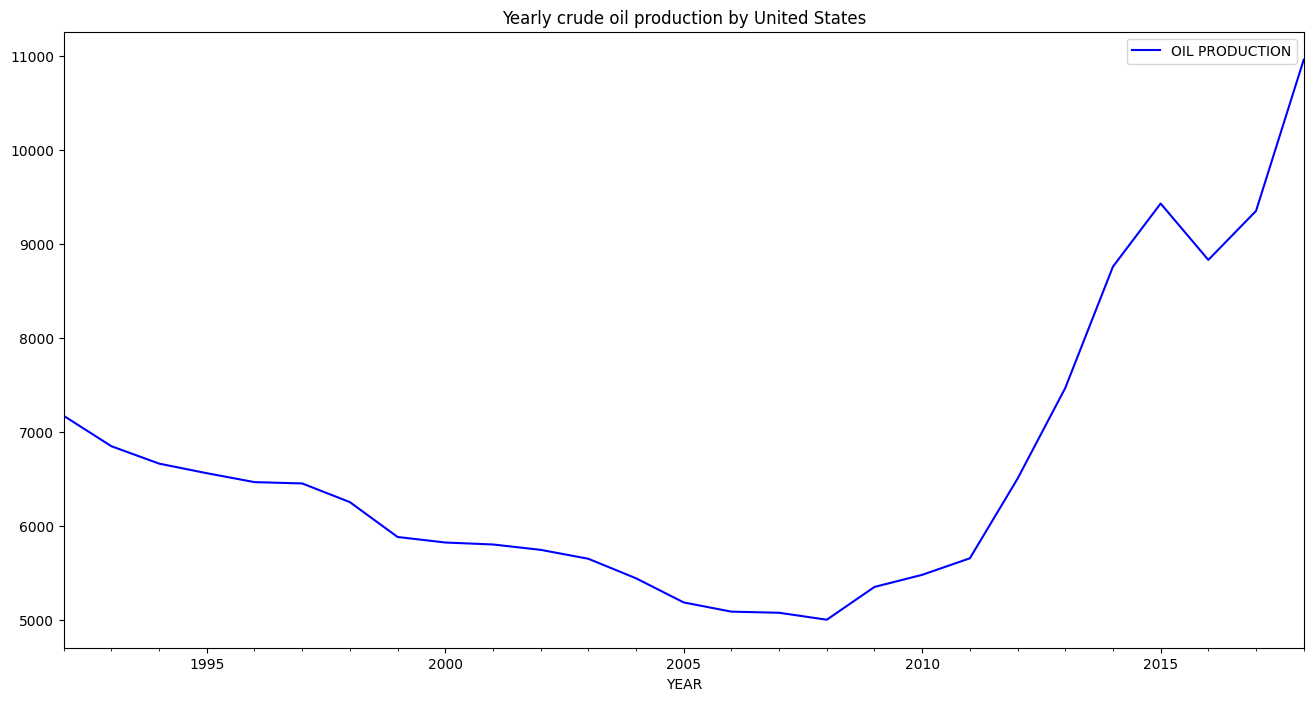

In [4]:
ax = united_states.plot(color = 'blue', figsize = (16, 8))

ax.set_title('Yearly crude oil production by United States')

plt.show()

- The above plot shows that the oil production of United States was declining from the early 1990s to the mid 2000s but has been increasing almost constantly since then.
- The higher oil production can be due to increasing population and hence, increasing the demand for transportation and other needs.

Let's now decompose the above time series into its various components, i.e., `trend`, `seasonality`, and `white noise`. Since this is yearly frequency data, there would not be any `seasonal` patterns after decomposing the time series.

The function, `seasonal_decompose`, decomposes the time series into `trend`, `seasonal`, and `white noise` components using moving averages. The decomposition results are obtained by first estimating the trend. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component. And whatever remains after getting `trend` and `seasonal` components, is known as the `white noise` or the `residual` component.

In [5]:
# Using seasonal_decompose function to decompose the time series into its individual components
decomposition = sm.tsa.seasonal_decompose(united_states)

In [6]:
# Creating an empty dataframe to store the individual components
decomposed_data = pd.DataFrame()

# Extracting the trend component of time series
decomposed_data['trend'] = decomposition.trend

# Extracting the seasonal component of time series
decomposed_data['seasonal'] = decomposition.seasonal

# Extracting the white noise or residual component of time series
decomposed_data['random_noise'] = decomposition.resid

Plotting the above three components in a single plot

<Axes: xlabel='YEAR'>

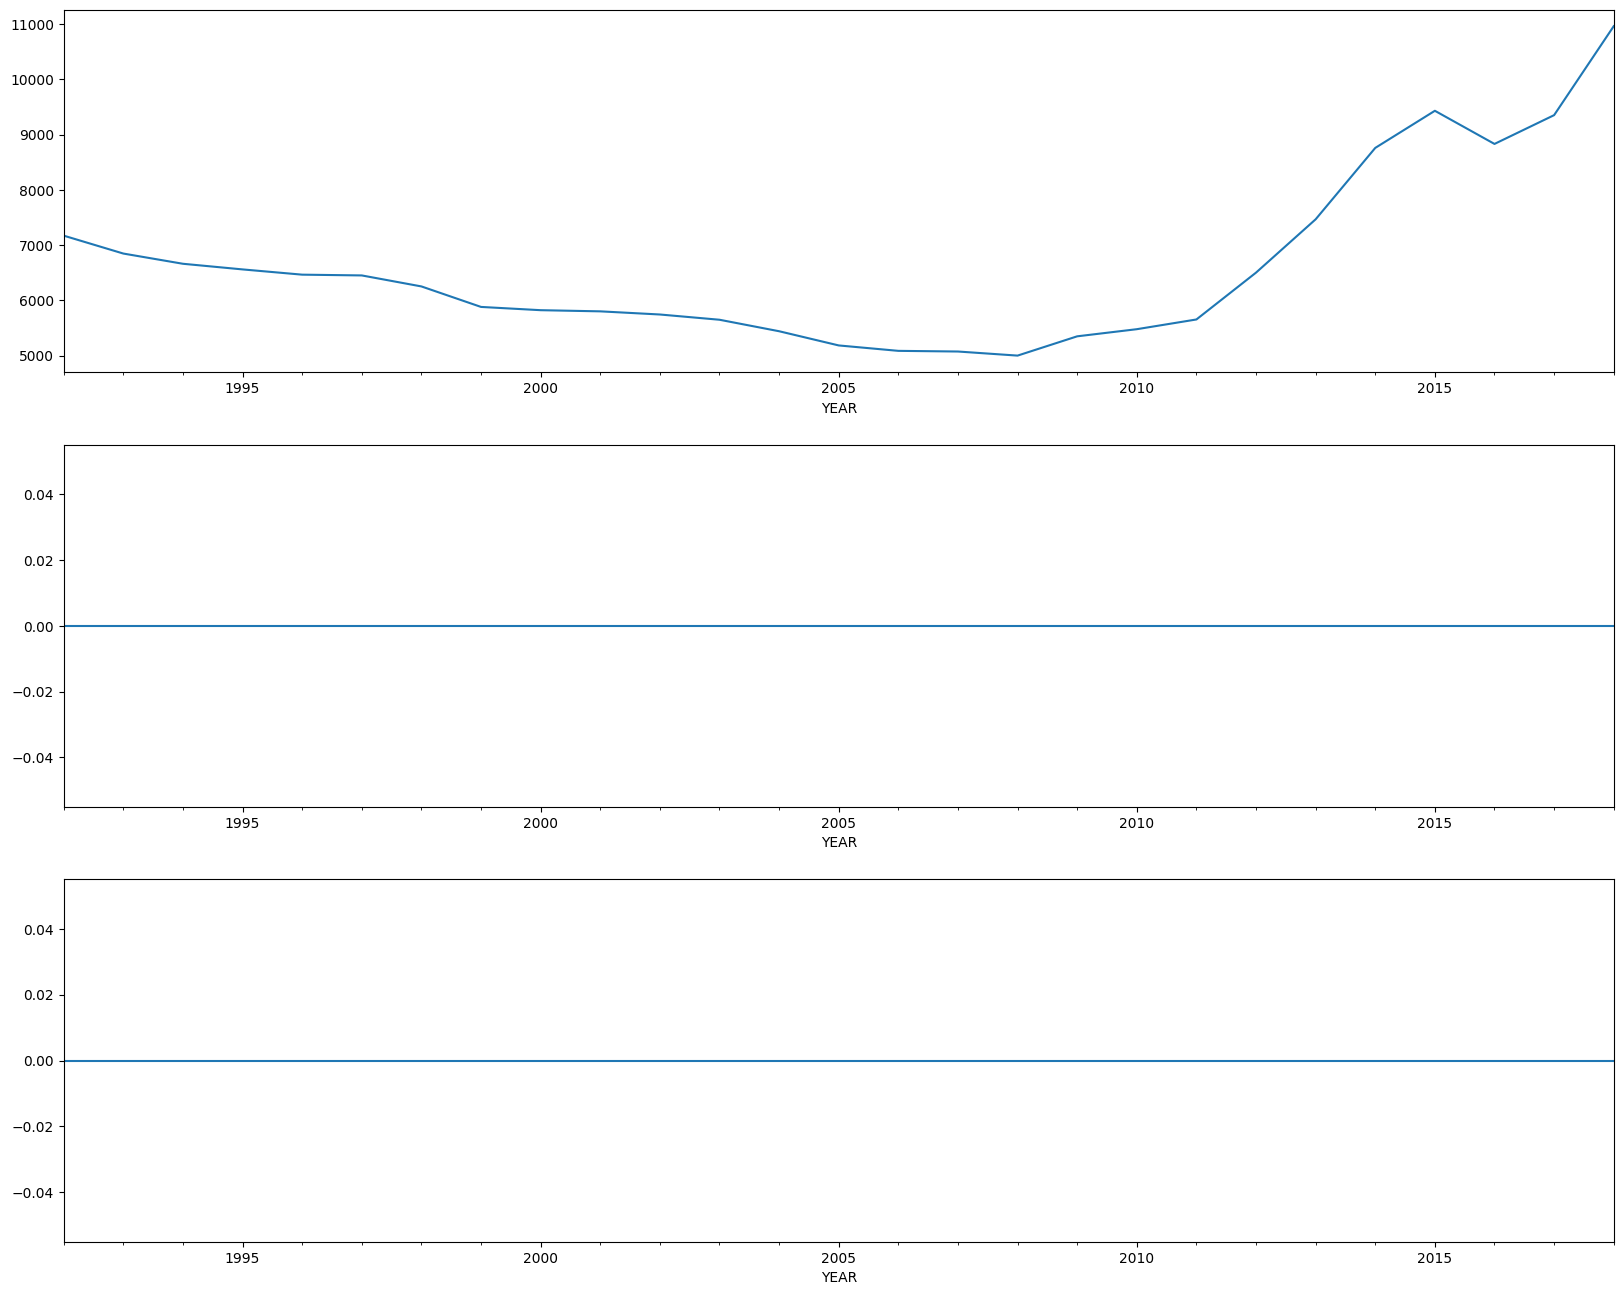

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 16))

decomposed_data['trend'].plot(ax = ax1)

decomposed_data['seasonal'].plot(ax = ax2)

decomposed_data['random_noise'].plot(ax = ax3)

As we can see from the above plot, the `seasonal` and `residual` components are zero, as this time series has a yearly frequency.

## **Splitting the dataset**

In [8]:
# Using the first 20 years data as the training data
train_data = united_states.loc['1992-01-01' : '2012-01-01']

# Using the last 7 years data as the test data
test_data = united_states.loc['2012-01-01':]

**Now, let's visualize the train and the test data in the same plot**

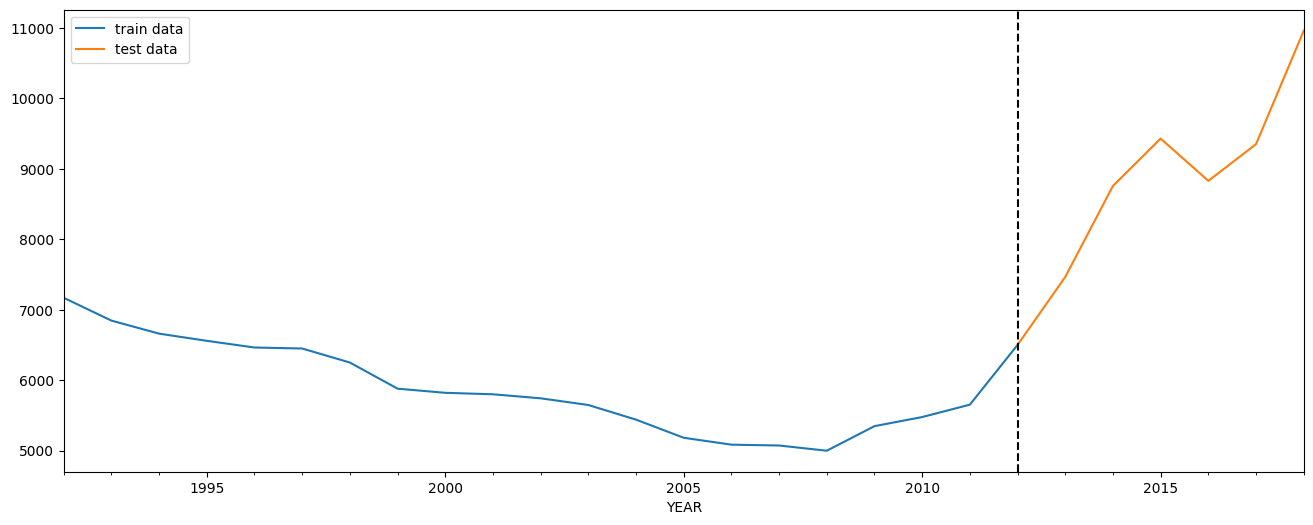

In [9]:
# Creating a subplot space
fig, ax = plt.subplots(figsize = (16, 6))

# Plotting train data
train_data.plot(ax = ax)

# Plotting test data
test_data.plot(ax = ax)

# Adding the legends in sequential order
plt.legend(['train data', 'test data'])

# Showing the time which divides the original data into train and test
plt.axvline(x = '2012-01-01', color = 'black', linestyle = '--')

# Showing the plot
plt.show()

## **Checking for stationarity**

Before building a time series model, we need to make sure that the time series is stationary. If the time series is non-stationary, then we need to make it stationary by differencing the data. The number of times we take a difference of the data is a parameter used in ARIMA models, which we will see shortly.

Non-stationarity in time series may appear for the following reasons: 
- Presence of a trend in the data
- Presence of heteroskedasticity
- Presence of autocorrelation

We can identify non-stationarity in the time series by performing a statistical test called the **Augmented Dicky-Fuller Test**.

- **Null Hypothesis:** The time series is non stationary
- **Alternate Hypothesis:** The time series is stationary

In [10]:
# Importing ADF test from statsmodels package
from statsmodels.tsa.stattools import adfuller

# Implementing ADF test on the original time series data
result = adfuller(train_data['OIL PRODUCTION'])

# Printing the results
print(result[0])

print(result[1]) # To get the p-value

print(result[4])

-0.582909852309165
0.8747971281795592
{'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}


Here, the p-value is around 0.87, which is higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. We can also see this visually by comparing the above ADF statistic and visually inspecting the time series.

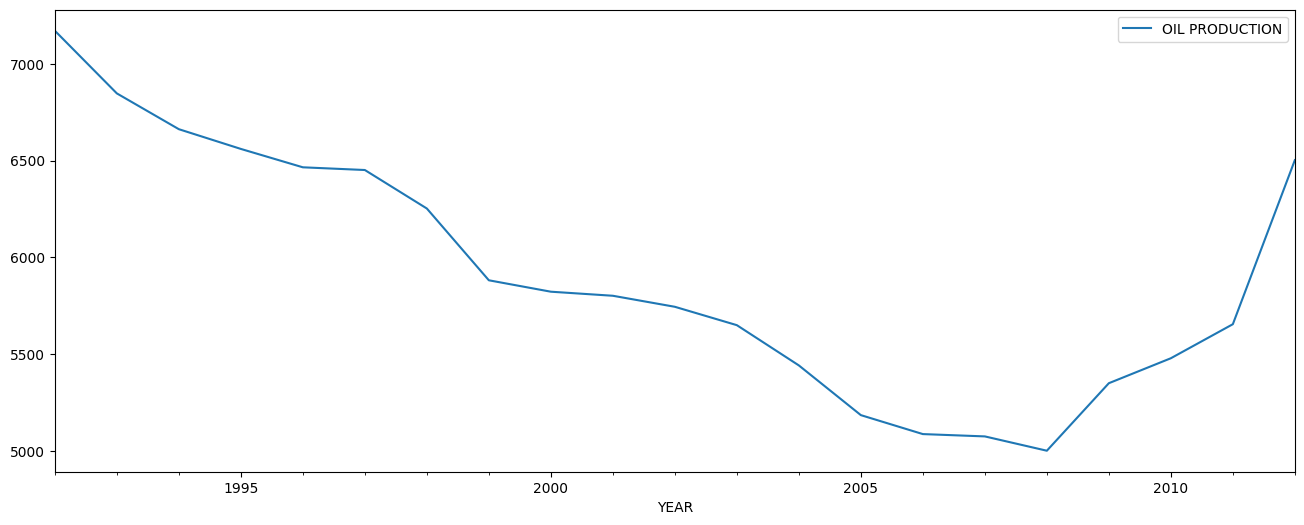

ADF Statistic: -0.582909852309165
p-value: 0.8747971281795592


In [11]:
# Implementing ADF test on the original time series data
result = adfuller(train_data['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Let now take the 1st order difference of the data and check if it becomes stationary or not.

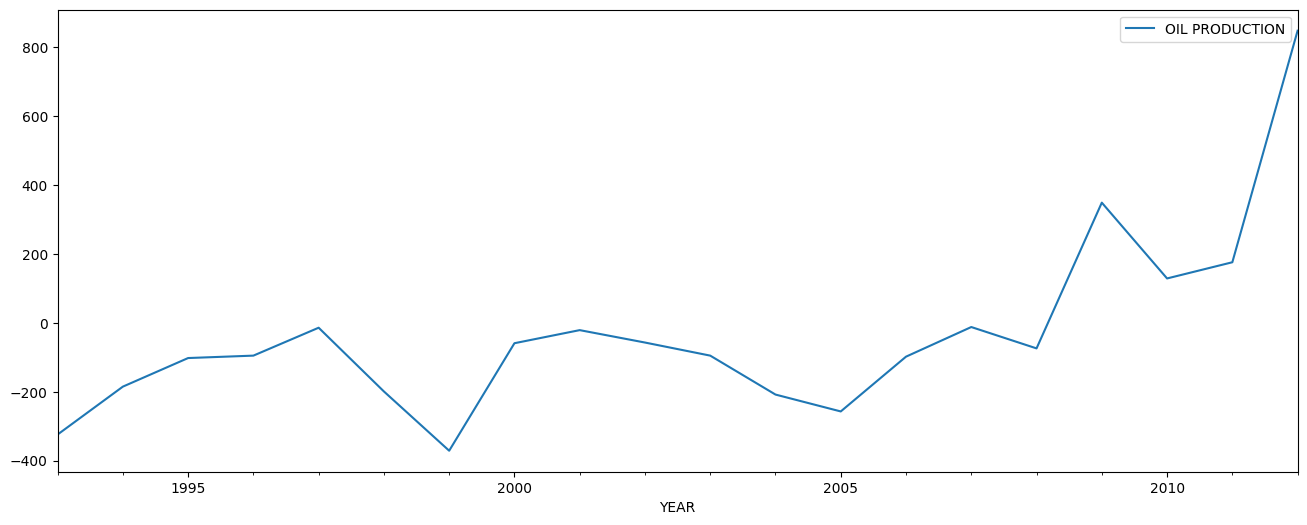

ADF Statistic: 1.5758007070600926
p-value: 0.9977831288888279


In [12]:
# Taking the 1st order differencing of the timeseries
train_data_stationary = train_data.diff().dropna()

# Implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Here, the p-value is around 0.99, which is again higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. Let's take the 2nd order differencing now and perform the same test.

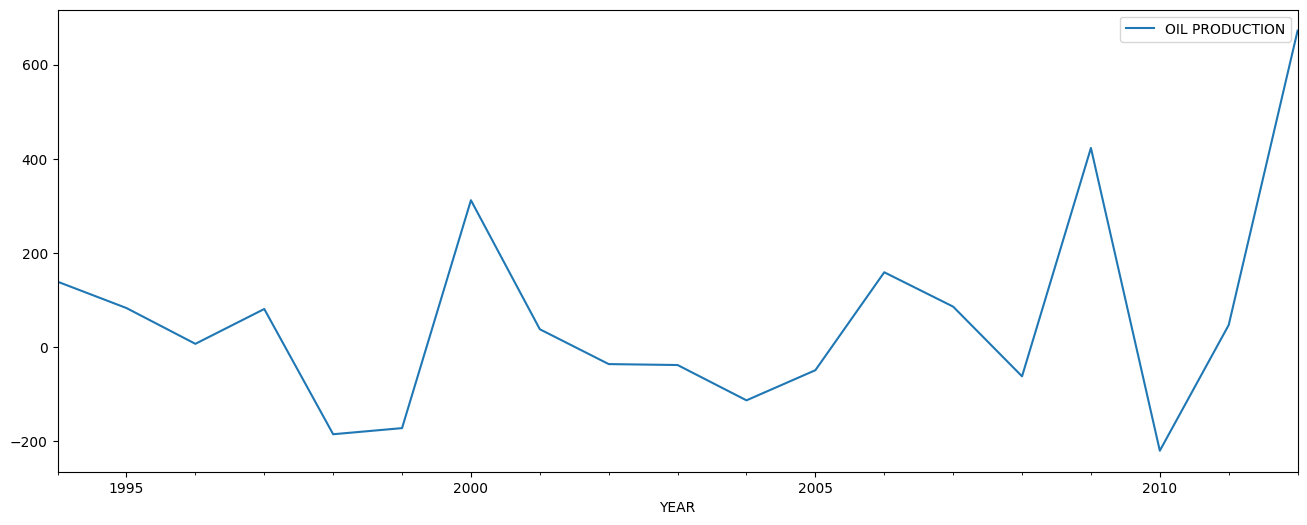

ADF Statistic: -1.558050660125612
p-value: 0.5046243689112162


In [13]:
# Taking the 2nd order differencing of the time series
train_data_stationary = train_data.diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Here, the p-value is around 0.50, which is again higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. Let's take the 3rd order differencing now and perform the same test.

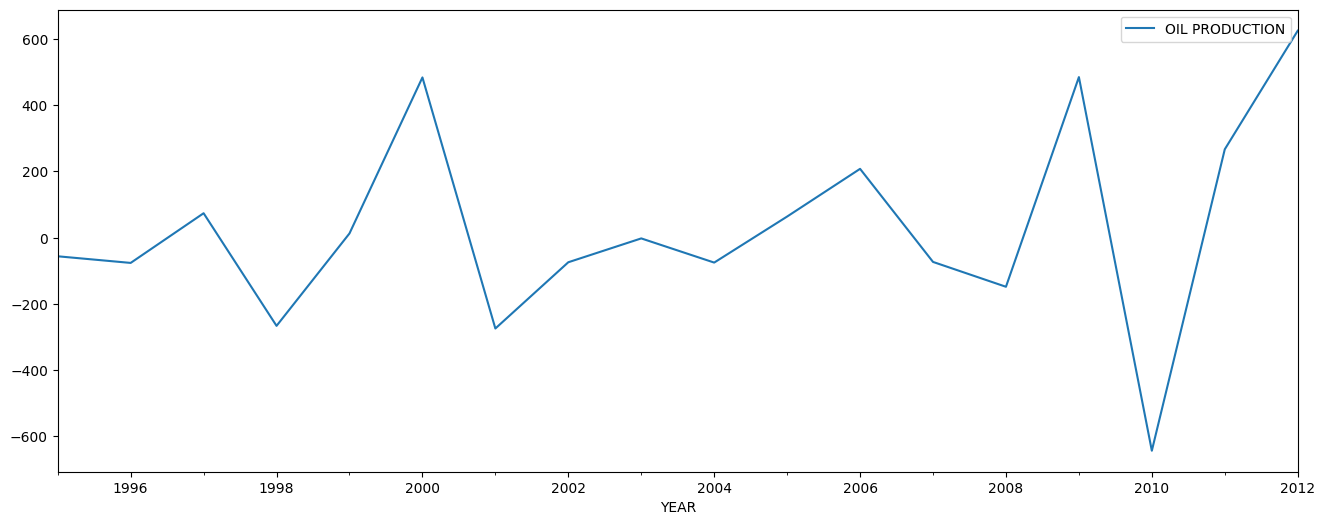

ADF Statistic: -6.191607528895949
p-value: 6.103650224876091e-08


In [14]:
# Taking the 3rd order differencing of the time series
train_data_stationary = train_data.diff().diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Now, the p-value is less than 0.05, and we can say that after taking 3rd order differencing, the time series became stationary. This parameter is also known as the **Integration** parameter (denoted by `d`) in ARIMA modeling, which we will see shortly. Here, d = 3.

## **ACF and PACF Plots**

ACF and PACF plots are used to identify the model's order in ARIMA models. These plots help to find the parameters `p` and `q`. Also, we always plot the ACF and PACF plots after making the time series stationary.

**Let's generate the ACF and PACF plots.**

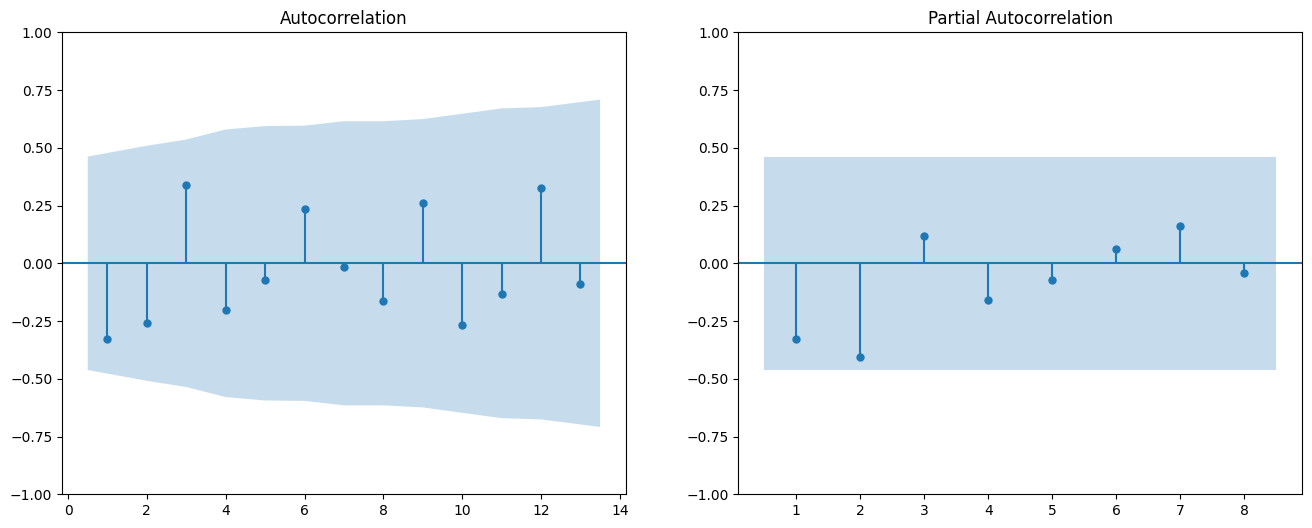

In [15]:
# Creating two subplots to show ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

# Creating and plotting the ACF charts starting from lag = 1
tsaplots.plot_acf(train_data_stationary, zero = False, ax = ax1)

# Creating and plotting the ACF charts starting from lag = 1 till lag = 8
tsaplots.plot_pacf(train_data_stationary, zero = False, ax = ax2, lags = 8)

plt.show()

From the above plots, it does not look like this stationary time series follows a pure AR or MA model. As none of the plots tails off or cuts off after any lag, it implies that the time series follows an ARMA or ARIMA model. So, to find out the optimal values of p, d, and q, we need to do a hyper-parameter search to find their optimal values.

The PACF seems to cut off at lag 2, but we cannot be sure because it is too close to the boundary.

Below we will try several different modeling techniques on this time series:
- AR (p)
- MA (q)
- ARMA (p, q)
- ARIMA (p, d, q)

and then we will check which one performs better.

## **Evaluation Metrics**

Before we build the model, we need to select which evaluation metric we want to optimize to build the model. There are several evaluation metrics to choose from for time series. Here, we will check the evaluation metrics - `AIC` and `RMSE`.

`AIC` and `RMSE` have different objectives or significance while selecting the best time series model. `RMSE` measures how far away the forecasts are in comparison to the actual values in the time series. It completely disregards the complexity of the model. Minimizing the `RMSE` provides very accurate results, but could lead to an overly complex model that captures too much noise in the data, which is also known as overfitting in the model.

But `AIC` has a different objective. `AIC` takes the error term and adds a penalty related to the number of predictors used in the model such that more complex models are penalized and allow to tradeoff between a `complex but accurate model`, against a `simpler but reasonably accurate model`.

So we need to make a decision based on the purpose of the model and the problem statement at hand while choosing the best evaluation metric.

## **AR Modeling**

Below we will build several AR models at different lags and try to understand whether the AR model will be a good fit or not. Below is a generalized equation for the AR model.

$$
y_{t}=a_{1} y_{t-1} + a_{2} y_{t-2} + \ldots + a_{p} y_{t-p} + \epsilon_{t}
$$

Here, we are building four AR models at lags 1, 2, 3, and 4.

In [16]:
# We are using the ARIMA function to build the AR model, so we need to pass the stationary time series that we got after double 
# differencing the original time series. Also, we will keep the q parameter as 0, so that the model acts as an AR model

# Creating an AR model with parameter p = 1
ar_1_model = ARIMA(train_data_stationary, order = (1, 0, 0))

# Creating an AR model with parameter p = 2
ar_2_model = ARIMA(train_data_stationary, order = (2, 0, 0))

# Creating an AR model with parameter p = 3
ar_3_model = ARIMA(train_data_stationary, order = (3, 0, 0))

# Creating an AR model with parameter p = 4
ar_4_model = ARIMA(train_data_stationary, order = (4, 0, 0))

In [17]:
# Fitting all the models that we implemented in the above cell

ar_1_results = ar_1_model.fit()

ar_2_results = ar_2_model.fit()

ar_3_results = ar_3_model.fit()

ar_4_results = ar_4_model.fit()

As we have passed the stationary time series while fitting the above AR models. The forecasts that we get will also be on the same scale, i.e., after doing double differencing of original time series. Therefore, to get the forecasts in the original scale, we need to **inverse transform** the time series data. The below function is helping us to do that inverse transformation.

In [18]:
def plot_predicted_output(results, ax):
    
    # We are taking double cumulative sum of forecasted values (which is inverse of double differencing)
    # And we are also adding the last element of the training data to the forecasted values to get back to the original scale
    predictions = np.cumsum(np.cumsum(results.predict(start = 19, end = 25))) + train_data.iloc[-1][0]
    
    # Setting indices of the test data into prediction values
    predictions.index = test_data.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train_data.plot(ax = ax, label = 'train', 
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    # Plotting the test data
    test_data.plot(ax = ax) 
    
    # Plotting the forecasted data
    predictions.plot(ax = ax)
    
    # Adding the legends sequentially
    ax.legend(['train data', 'test data', 'forecasted values'])

**Now, let's plot the forecasted values from all the four models, and then compare the model outputs.**

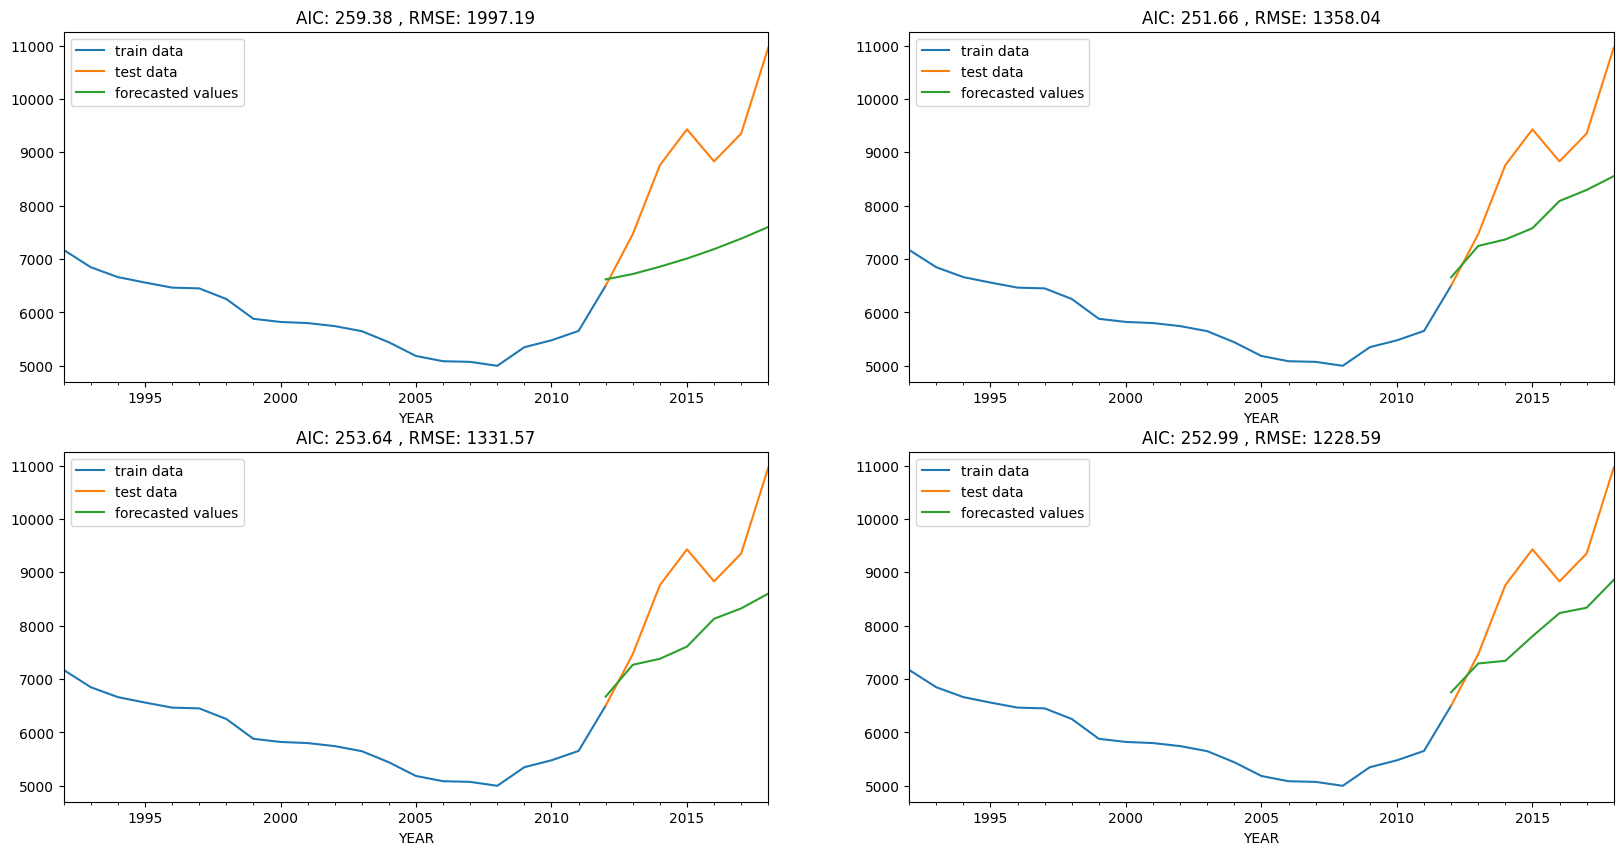

In [19]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_1_results, ax1)

plot_predicted_output(ar_2_results, ax2)

plot_predicted_output(ar_3_results, ax3)

plot_predicted_output(ar_4_results, ax4)

plt.show()

As we can see from the above results, out of these four models we have developed, the AIC values for all these models are very much comparable or approximately the same. But if we check the RMSE values, it is the least for AR(4) or ARIMA(4, 0, 0) model, and it is significantly less than the other three models. Based on this analysis, AR(4) or ARIMA(4, 0, 0) looks the best model if we only want to use the AR component while modeling. 

**Let's now check the model summary of this AR(4) or ARIMA(4, 0, 0) model.**

In [20]:
ar_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -120.495
Date:                Mon, 15 May 2023   AIC                            252.990
Time:                        13:51:36   BIC                            258.332
Sample:                    01-01-1995   HQIC                           253.727
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0306     17.221      0.466      0.641     -25.722      41.783
ar.L1         -0.8563      0.371     -2.308      0.021      -1.583      -0.129
ar.L2         -1.0208      0.534     -1.911      0.056      -2.067       0.026
ar.L3         -0.3271      0.410     -0.799      0.425      -1.130       0.476
ar.L4         -0.4350      0.340     -1.280      0.201      -1.101       0.231
sigma2      3.249e+04   2.03e+04      1.600      0.110   -7311.525    7.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.45   Prob(JB):                         0.83
Heteroskedasticity (H):               2.22   Skew:                             0.10
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the equation for this model would be:

$$
y_{t}= 8.0306 - 0.8563 y_{t-1} - 1.0208 y_{t-2} - 0.3271 y_{t-3} - 0.4350 y_{t-4} + \epsilon_{t}
$$

## **MA Modeling**

Now, we will build several MA models at different lags and try to understand whether the MA model will be a good fit or not in comparison to the AR models that we have built so far. Below is a generalized equation for the MA model.

$$
y_{t}=m_{1} \epsilon_{t-1} + m_{2} \epsilon_{t-2} + \ldots+m_{q} \epsilon_{t-q} + \epsilon_{t}
$$

In [21]:
# We are using the ARIMA function to build the MA model, so we need to pass the stationary time series that we got after double 
# differencing the original time series. Also, we will keep the p parameter as 0 so that the model acts as an MA model

# Creating MA model with parameter q = 1
ma_1_model = ARIMA(train_data_stationary, order = (0, 0, 1))

# Creating MA model with parameter q = 2
ma_2_model = ARIMA(train_data_stationary, order = (0, 0, 2))

# Creating MA model with parameter q = 3
ma_3_model = ARIMA(train_data_stationary, order = (0, 0, 3))

# Creating MA model with parameter q = 4
ma_4_model = ARIMA(train_data_stationary, order = (0, 0, 4))

In [22]:
# Fitting all the models that we implemented in the above cell

ma_1_results = ma_1_model.fit()

ma_2_results = ma_2_model.fit()

ma_3_results = ma_3_model.fit()

ma_4_results = ma_4_model.fit()

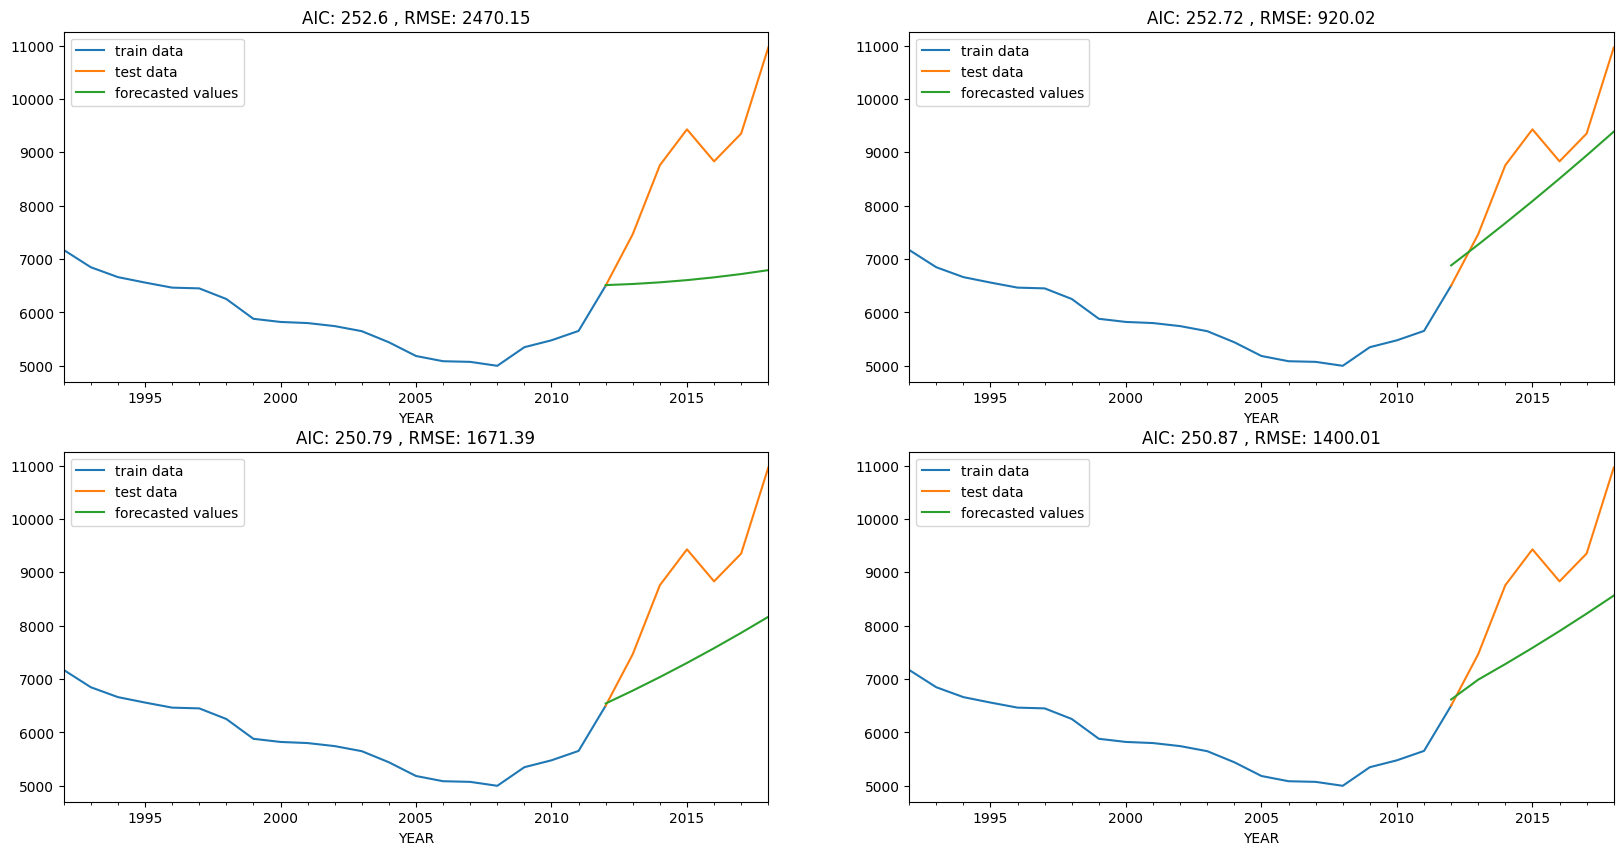

In [23]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ma_1_results, ax1)

plot_predicted_output(ma_2_results, ax2)

plot_predicted_output(ma_3_results, ax3)

plot_predicted_output(ma_4_results, ax4)

plt.show()

As we can see from the above plots, again all the models that we have developed so far are comparable to AIC, but RMSE is significantly lower for MA(2) model in comparison to all the other models. So, the best model that we have got using MA modeling, is MA(2) or ARIMA(0, 0, 2). This also aligns with our observation that PACF plot seems to cut off at lag 2.  

**Let's analyze the model summary for MA(2) or ARIMA(0, 0, 2) below.**

In [24]:
ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -122.361
Date:                Mon, 15 May 2023   AIC                            252.721
Time:                        13:51:36   BIC                            256.283
Sample:                    01-01-1995   HQIC                           253.212
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8987     12.355      0.882      0.378     -13.317      35.115
ma.L1         -1.6981      3.184     -0.533      0.594      -7.939       4.543
ma.L2          0.9760      3.592      0.272      0.786      -6.064       8.015
sigma2      3.458e+04    1.1e+05      0.315      0.752    -1.8e+05    2.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.54   Prob(JB):                         0.66
Heteroskedasticity (H):               1.59   Skew:                             0.51
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **ARMA Modeling**

From the above two models (i.e., AR and MA) that we have built so far, it looks like we have got a better model at AR(3) and MA(0) on the differenced (i.e., stationary) time series data. Now, we will build several ARMA models with different combinations of p and q parameters on the differenced time series data. And we will evaluate those models based on `AIC` and `RMSE`. Let's build those models.

Below is a generalized equation for the ARMA model.

$$
y_{t}=a_{1} y_{t-1}+m_{1} \epsilon_{t-1} + \ldots + \epsilon_{t}
$$

In [25]:
# We are using the ARIMA function here, so we need to pass stationary time series that we got after double differencing the 
# original time series

# Creating an ARMA model with parameters p = 2 and q = 1
ar_2_ma_1_model = ARIMA(train_data_stationary, order = (2, 0, 1))

# Creating an ARMA model with parameters p = 2 and q = 2
ar_2_ma_2_model = ARIMA(train_data_stationary, order=(2, 0, 2))

# Creating an ARMA model with parameters p = 3 and q = 2
ar_3_ma_2_model = ARIMA(train_data_stationary, order = (3, 0, 2))

# Creating an ARMA model with parameters p = 2 and q = 3
ar_2_ma_3_model = ARIMA(train_data_stationary, order = (2, 0, 3))

In [26]:
# Fitting all the models that we implemented in the above cell

ar_2_ma_1_results = ar_2_ma_1_model.fit()

ar_2_ma_2_results = ar_2_ma_2_model.fit()

ar_3_ma_2_results = ar_3_ma_2_model.fit()

ar_2_ma_3_results = ar_2_ma_3_model.fit()

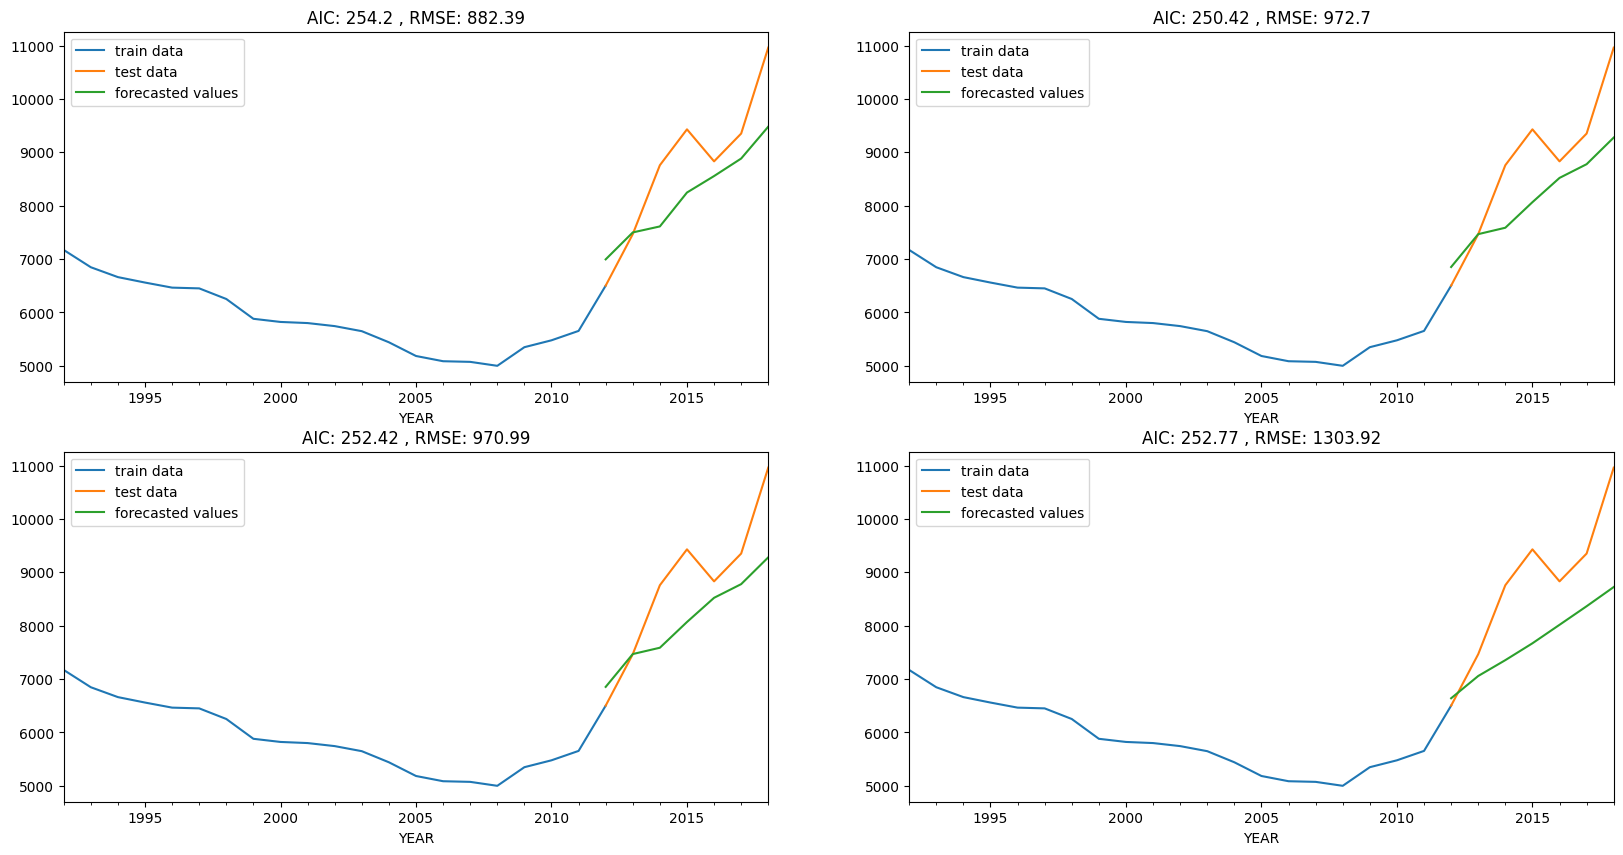

In [27]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_2_ma_1_results, ax1)

plot_predicted_output(ar_2_ma_2_results, ax2)

plot_predicted_output(ar_3_ma_2_results, ax3)

plot_predicted_output(ar_2_ma_3_results, ax4)

plt.show()

As we can see from the above plots, again all the models that we have developed so far have comparable AIC, but for one specific model, i.e., ARIMA(2, 0, 1), the `RMSE` is significantly lower than the models that we have developed above. Also, it is evident from the above plots that the forecasted values from the model ARIMA(2, 0, 1) are closer to the test data in comparison to all the other models.

**Let's analyze the summary for the model ARIMA(2, 0, 1).**

In [28]:
ar_2_ma_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -122.099
Date:                Mon, 15 May 2023   AIC                            254.198
Time:                        13:51:37   BIC                            258.649
Sample:                    01-01-1995   HQIC                           254.811
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5731     35.290      0.243      0.808     -60.594      77.740
ar.L1         -1.2897      0.178     -7.235      0.000      -1.639      -0.940
ar.L2         -0.8188      0.250     -3.279      0.001      -1.308      -0.329
ma.L1          0.9853      2.569      0.384      0.701      -4.050       6.020
sigma2      3.605e+04   8.56e+04      0.421      0.674   -1.32e+05    2.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.23   Prob(JB):                         0.83
Heteroskedasticity (H):               1.75   Skew:                             0.12
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **ARIMA Modeling**

So far, we have built several AR, MA, and ARMA models, and while building those models, it is necessary to make the time series stationary. But while building ARIMA models, we can directly pass the non-stationary time series, as the new parameter which is required in ARIMA modeling, i.e., `d` parameter (along with parameters `p` and `q`) will automatically difference the data to make the time series stationary.

In [29]:
train_data = train_data.astype('float32')

We are using the ARIMA function here, so we do not need to pass stationary time series, we can simply pass the original time without differencing, and pass the parameter d = 3, as we already know that after triple differencing the original time series becomes a stationary time series.

In [30]:
# Creating an ARIMA model with parameters p = 2, d = 3 and q = 1
ar_2_d_3_ma_1_model = ARIMA(train_data, order = (2, 3, 1))

# Creating an ARIMA model with parameters p = 1, d = 3 and q = 2
ar_1_d_3_ma_2_model = ARIMA(train_data, order = (1, 3, 2))

# Creating an ARIMA model with parameters p = 2, d = 3 and q = 2
ar_2_d_3_ma_2_model = ARIMA(train_data, order = (2, 3, 2))

# Creating an ARIMA model with parameters p = 3, d = 3 and q = 2
ar_3_d_3_ma_2_model = ARIMA(train_data, order = (3, 3, 2))

In [31]:
# Fitting all the models that we implemented in the above cell

ar_2_d_3_ma_1_results = ar_2_d_3_ma_1_model.fit()

ar_1_d_3_ma_2_results = ar_1_d_3_ma_2_model.fit()

ar_2_d_3_ma_2_results = ar_2_d_3_ma_2_model.fit()

ar_3_d_3_ma_2_results = ar_3_d_3_ma_2_model.fit()

Before we plot the forecasted values, we need to update the plot_predicted_output() function because the ARIMA model predicts the transformed values and hence we don't need to perform operations of the cumulative sum to inverse transform the predicted values.

In [32]:
def plot_predicted_output_new(results, ax):
    
    predictions = results.predict(start = 19, end = 25)
    
    # Setting indices of the test data into prediction values
    predictions.index = test_data.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train_data.plot(ax = ax, label = 'train', 
                    
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    # Plotting the test data
    test_data.plot(ax = ax) 
    
    # Plotting the forecasted data
    predictions.plot(ax = ax)
    
    # Adding the legends sequentially
    ax.legend(['train data', 'test data', 'forecasted values'])

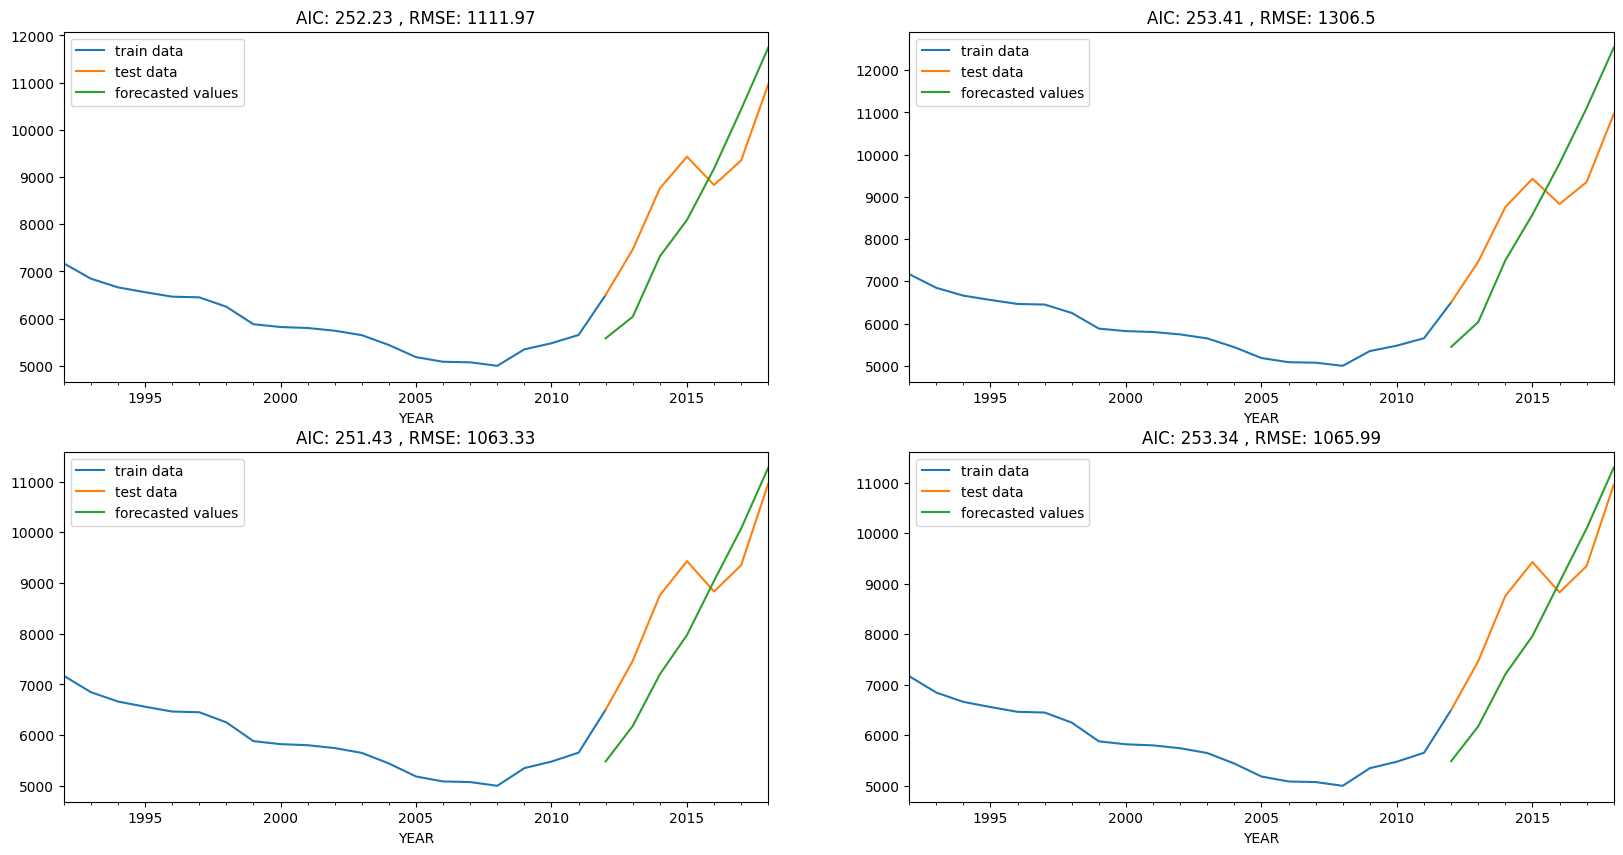

In [33]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output_new(ar_2_d_3_ma_1_results, ax1)

plot_predicted_output_new(ar_1_d_3_ma_2_results, ax2)

plot_predicted_output_new(ar_2_d_3_ma_2_results, ax3)

plot_predicted_output_new(ar_3_d_3_ma_2_results, ax4)

plt.show()

From the above analysis, we can see that the ARIMA(2, 3, 2) is the best model in comparison to others, as it has comparable AIC to other models and less RMSE in comparison to all the other models.

**Let's analyze the model summary for ARIMA(2, 3, 2).**

In [34]:
ar_2_d_3_ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   21
Model:                 ARIMA(2, 3, 2)   Log Likelihood                -120.713
Date:                Mon, 15 May 2023   AIC                            251.427
Time:                        13:51:37   BIC                            255.879
Sample:                    01-01-1992   HQIC                           252.041
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9701      0.276     -3.518      0.000      -1.511      -0.430
ar.L2         -0.5351      0.318     -1.685      0.092      -1.158       0.087
ma.L1          0.2168      7.403      0.029      0.977     -14.293      14.726
ma.L2         -0.7778      6.047     -0.129      0.898     -12.630      11.074
sigma2      2.577e+04   1.97e+05      0.131      0.896   -3.61e+05    4.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.41   Prob(JB):                         0.64
Heteroskedasticity (H):               1.85   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Now that we have identified the best parameters (p, d, and q) for our data. Let's train the model with the same parameters on the full data for United States and get the forecasts for the next 7 years, i.e., from 2019-01-01 to 2025-01-01.**

In [35]:
final_model = ARIMA(united_states, order = (2, 3, 2))

final_model_results = final_model.fit()

In [36]:
forecasted_ARIMA = final_model_results.predict(start = '2019-01-01', end = '2025-01-01')

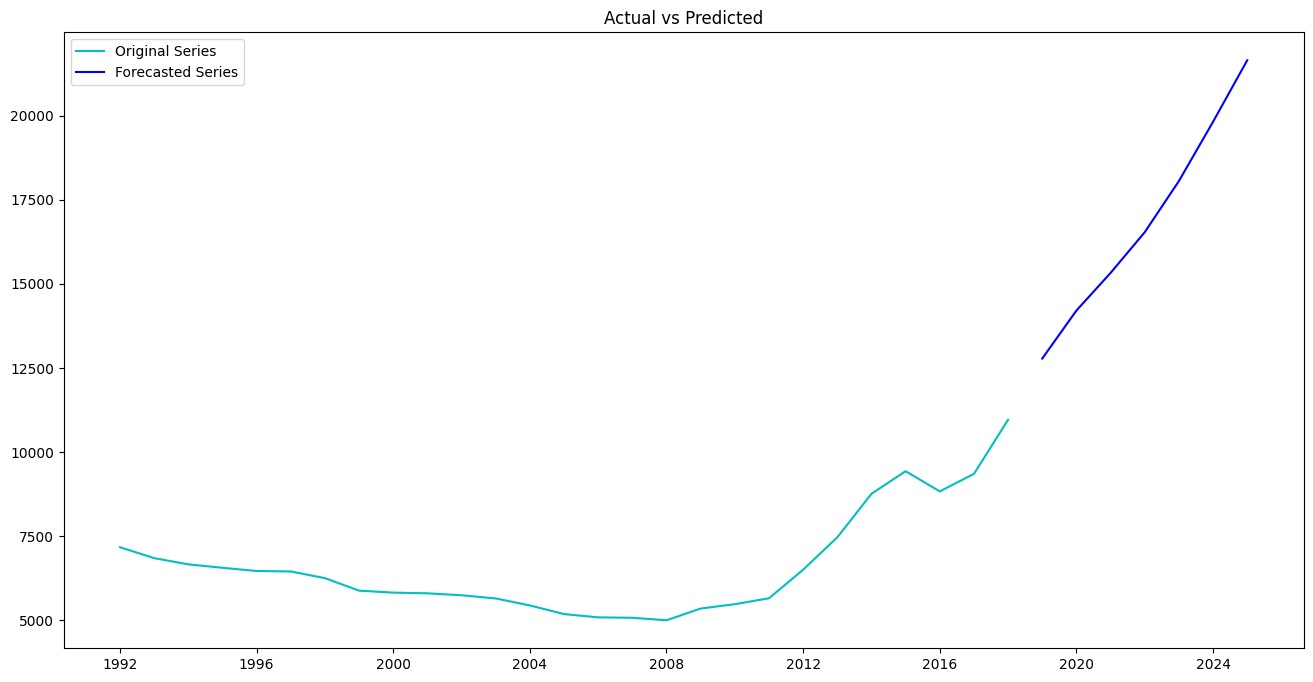

In [37]:
# Plotting the original time seris with forecast

plt.figure(figsize = (16, 8))

plt.plot(united_states, color = 'c', label = 'Original Series')

plt.plot(forecasted_ARIMA, label = 'Forecasted Series', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

- The above plot shows that the model is able to identify the trend in the data and forecast the values accordingly. 
- The forecast indicates that, according to the historic data, the oil production is going to constantly increase for United Sates.

## **Conclusion**

 - We have built different types of models using search for the optimal parameters for each. We have compared all the models based on the evaluation metrics `AIC` and `RMSE`.
 - The AIC for all the models is approximately the same, i.e., there is no significant difference in the AIC values for all the models. But, we can see significant difference in some of the models in terms of RMSE. So, the choice of model is more dependent on RMSE for the current data.
 - Overall, the model `ARIMA(2, 3, 2) has given the best results` and we have used the same to forecast the oil production for United States.

## **Additional Model - Auto ARIMA**

Alternatively, we can also model this time series `automatically`, without needing to go through all the steps that we have gone through so far. In the below piece of code, when we pass the training data, it automatically finds the best parameters for you and then model the time series as shown below.

In [38]:
import pmdarima as pm

auto_arima_model = pm.auto_arima(train_data, d = 3, seasonal = False, trace = True, 
                                 error_action = 'ignore', suppress_warnings = True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=258.092, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=257.788, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=252.229, Time=0.01 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=254.063, Time=0.02 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=252.880, Time=0.01 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.01 sec

Best model:  ARIMA(0,3,1)(0,0,0)[0]          
Total fit time: 0.109 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 3, 1)   Log Likelihood                -124.115
Date:                Mon, 15 May 2023   AIC                            252.229
Time:                        13:51:38   BIC             

The auto-arima model is also giving out the best model as - `ARIMA(0, 3, 1)(0, 0, 0)[0]`, which is different from what we have chosen earlier. There are two important points to remember here: 

- In the best model that we have got, the last four parameters are zeros. Those are the parameters that are responsible for capturing the `seasonality in the time series`. Since this time series has a yearly frequency, it is expected that it will not have any seasonal patterns.
- Also, auto-arima tries to minimize the `AIC`, rather than `RMSE` of the model. So, we need to compute the RMSE of these models manually, to check whether the model has acceptable RMSE or not. The best model from auto-arima might not have a good/acceptable RMSE score.

**We can also plot and analyze the model diagnostics for residuals as shown below**

If the residuals are normally distributed and are uncorrelated to each other, then we actually have a good model.

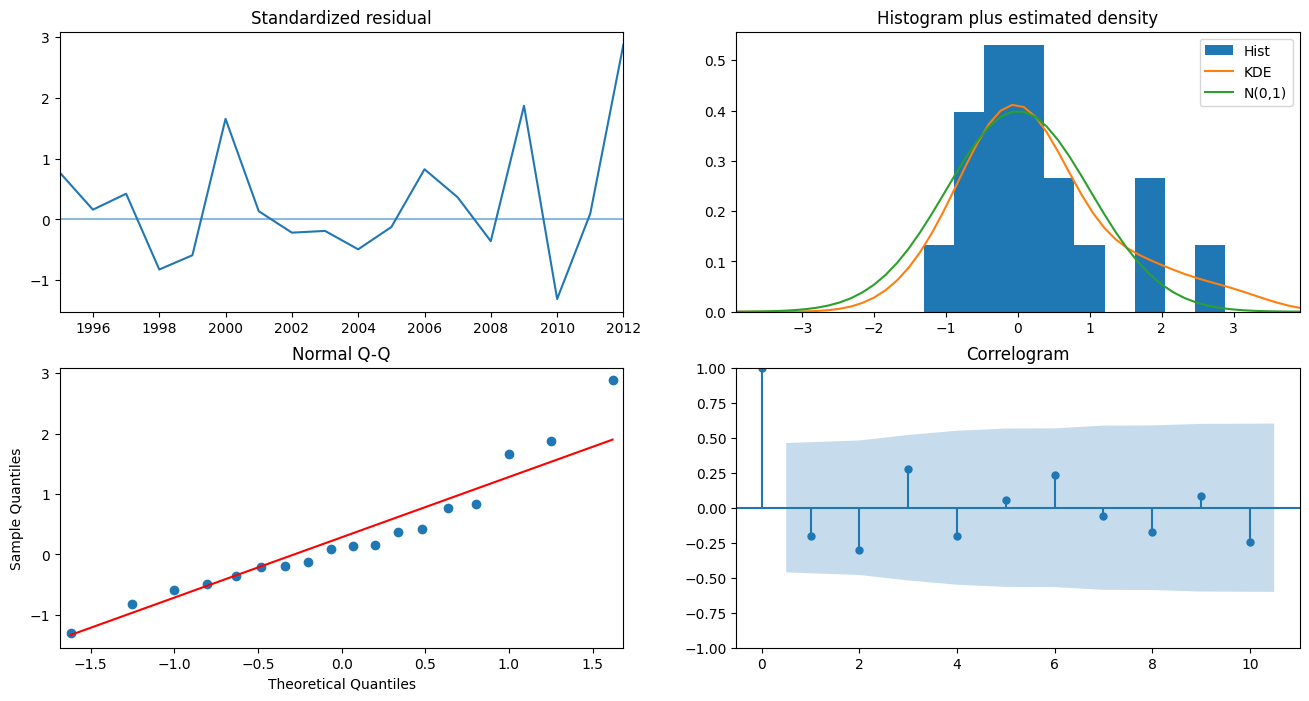

In [39]:
fig = plt.figure(figsize = (16, 8))

fig = auto_arima_model.plot_diagnostics(fig = fig)

**Observations:**

- **Top left**: The residual errors seem to fluctuate around a mean of zero and have a approximately uniform variance.

- **Top Right**: The density plot suggests that the distribution of residuals is very close to a standard normal distribution.

- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution of residuals is skewed.

- **Bottom Right**: The ACF plot shows the residual errors are not autocorrelated as no lag other than 0 is significant. Any autocorrelation would imply that there is some pattern in the residual errors that is not explained by the model.